# A comparative analysis of constituencies in England and Wales

This is the code associated with the cluster analysis of constituencies in England and Wales. We start by importing the packages we need and downloading the relevant data sets.

In [525]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup # data wrangling
import opencage.geocoder # fetches coordinates
import requests  # url scraping
from urllib import request # url scraping
import folium # displays maps
from sklearn.cluster import DBSCAN # density-based clustering algorithm
from sklearn.cluster import KMeans # K-means clustering algorithm
from sklearn.decomposition import PCA # dimension reduction
from re import sub # regular expressions
import pickle # saving dataframes

# used to generate colours for markers on maps
import matplotlib.cm as cm
import matplotlib.colors as colors
from random import shuffle

## Constituencies

Next we load in our constituency data.

In [528]:
with open('constituencies.csv', 'r') as csv:
    constituencies = pd.read_csv(csv, usecols=[0,1,2,7])

print(constituencies.shape)
constituencies.head()

(650, 4)


,Constituency,Latitude,Longitude,Code
0,Aldershot,51.277500,-0.762801,E14000530
1,Aldridge-Brownhills,52.614201,-1.927900,E14000531
2,Altrincham and Sale West,53.394199,-2.342090,E14000532
3,Amber Valley,53.047901,-1.388680,E14000533
4,Arundel and South Downs,50.912498,-0.415972,E14000534


## Population and average age

We now extract two of our variables: total population and average age.

In [529]:
with open('population_2017.csv', 'r') as file:
    population = pd.read_csv(
            file, 
            header = 4, 
            names = ['id', 'Constituency', 'Population'] + list(range(90)) + [90],
            usecols = lambda x: x not in ['id'])

print(population.shape)
population.head()

(573, 93)


,Constituency,Population,0,1,2,3,4,5,6,7,...,81,82,83,84,85,86,87,88,89,90
0,Aldershot,"106,193","1,362","1,498","1,492","1,412","1,441","1,429","1,348","1,376",...,411,404,379,288,280,241,250,229,184,717
1,Aldridge-Brownhills,"77,532",786,780,837,826,809,836,883,842,...,568,506,453,442,422,376,350,256,224,829
2,Altrincham and Sale West,"101,457","1,065","1,264","1,193","1,303","1,304","1,433","1,444","1,425",...,565,515,506,428,441,399,393,335,286,"1,128"
3,Amber Valley,"90,132",938,914,921,920,"1,033",993,"1,010","1,051",...,493,452,412,387,335,288,285,253,211,871
4,Arundel and South Downs,"100,501",802,863,945,936,979,"1,112","1,117","1,164",...,828,761,664,615,574,574,504,445,399,"1,455"


We note that the numbers in this data set is of the wrong type:

In [530]:
population.dtypes[:5]

Constituency    object
Population      object
0               object
1               object
2               object
dtype: object

We therefore apply the following function, <tt>str_to_int</tt>, which changes the numeral strings to actual numerals.

In [531]:
def str_to_int(x):
    try:
        if type(x) == type('x'):
            return int(x.replace(',',''))
        else:
            return x
    except:
        return np.nan
    
for col in population.columns[1:]:
    population[col] = population[col].apply(str_to_int)
    
print(population.dtypes[:5])
population.head()

Constituency    object
Population       int64
0                int64
1                int64
2                int64
dtype: object


,Constituency,Population,0,1,2,3,4,5,6,7,...,81,82,83,84,85,86,87,88,89,90
0,Aldershot,106193,1362,1498,1492,1412,1441,1429,1348,1376,...,411,404,379,288,280,241,250,229,184,717
1,Aldridge-Brownhills,77532,786,780,837,826,809,836,883,842,...,568,506,453,442,422,376,350,256,224,829
2,Altrincham and Sale West,101457,1065,1264,1193,1303,1304,1433,1444,1425,...,565,515,506,428,441,399,393,335,286,1128
3,Amber Valley,90132,938,914,921,920,1033,993,1010,1051,...,493,452,412,387,335,288,285,253,211,871
4,Arundel and South Downs,100501,802,863,945,936,979,1112,1117,1164,...,828,761,664,615,574,574,504,445,399,1455


### Total population

For our first variable, we slice out the relevant data from the population dataframe, analyse it and normalise it.

In [532]:
tot_pop = population[['Constituency', 'Population']].copy()

tot_pop.head()

,Constituency,Population
0,Aldershot,106193
1,Aldridge-Brownhills,77532
2,Altrincham and Sale West,101457
3,Amber Valley,90132
4,Arundel and South Downs,100501


In [533]:
tot_pop.describe()

,Population
count,573.000000
mean,102521.108202
std,15951.486330
min,58941.000000
25%,92793.000000
50%,100945.000000
75%,110809.000000
max,185200.000000


In [534]:
# normalise data
tot_pop_norm = tot_pop[['Constituency']].copy()

tot = tot_pop['Population']
tot_pop_norm['Population'] = (tot - tot.mean()) / tot.std()

tot_pop_norm.head()

,Constituency,Population
0,Aldershot,0.230191
1,Aldridge-Brownhills,-1.566569
2,Altrincham and Sale West,-0.066709
3,Amber Valley,-0.776674
4,Arundel and South Downs,-0.126641


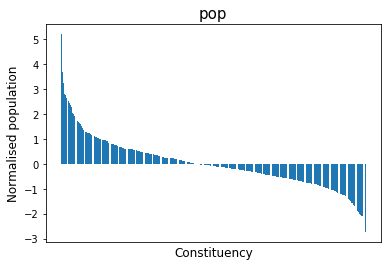

In [535]:
sorted_tot_pop = tot_pop_norm.sort_values(by=['Population'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_tot_pop['Constituency'], height=sorted_tot_pop['Population'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised population', fontsize=12)
plt.title('pop', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

### Average age

Doing the same thing with average age, we slice out the relevant information from the population dataframe, analyse it and normalise it.

In [536]:
avg_age = population[['Constituency']].copy()
avg_age['Avg age'] = np.sum([population[i] / population['Population'] * i for i in range(0,91)], axis=0)

avg_age.head()

,Constituency,Avg age
0,Aldershot,38.408106
1,Aldridge-Brownhills,43.442024
2,Altrincham and Sale West,40.552323
3,Amber Valley,42.640183
4,Arundel and South Downs,46.161949


In [537]:
avg_age.describe()

,Avg age
count,573.000000
mean,40.351896
std,3.460208
min,30.399155
25%,38.194240
50%,40.641516
75%,42.806370
max,49.511447


In [538]:
# normalise data
avg_age_norm = avg_age[['Constituency']].copy()
age = avg_age['Avg age']
avg_age_norm['Avg age'] = (age - age.mean()) / age.std()

avg_age_norm.head()

,Constituency,Avg age
0,Aldershot,-0.561755
1,Aldridge-Brownhills,0.893047
2,Altrincham and Sale West,0.057923
3,Amber Valley,0.661315
4,Arundel and South Downs,1.679105


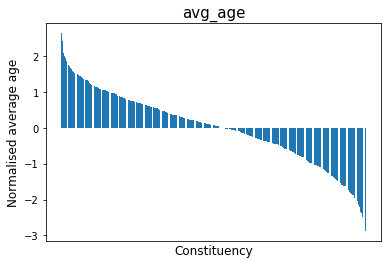

In [539]:
sorted_avg_age = avg_age_norm.sort_values(by=['Avg age'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_avg_age['Constituency'], height=sorted_avg_age['Avg age'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised average age', fontsize=12)
plt.title('avg_age', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

Given our first two variables, the distribution of our constituencies looks as follows.

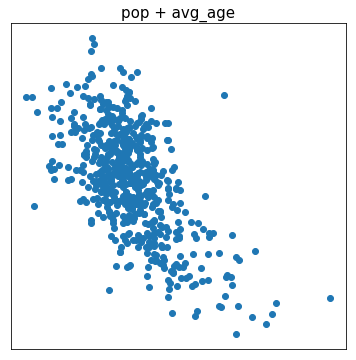

In [540]:
# plot the constituencies
fig = plt.figure(figsize=(6,6))

x = tot_pop_norm.drop('Constituency', axis=1)
y = avg_age_norm.drop('Constituency', axis=1)

plt.scatter(x, y)
plt.title('pop + avg_age', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.show()

## Area

We now deal with our second variable in the same way.

In [541]:
with open('area_2015.csv', 'r') as csv:
    area = pd.read_csv(csv, usecols = [1,2], header = 0, names = ['Constituency', 'Area'])

print(area.shape)
area.head()

(632, 2)


,Constituency,Area
0,Aldershot,5297.82
1,Aldridge-Brownhills,4401.65
2,Altrincham and Sale West,5092.94
3,Amber Valley,12464.64
4,Arundel and South Downs,64651.29


In [542]:
area.describe()

,Area
count,6.320000e+02
mean,3.708839e+04
std,8.827636e+04
min,7.380400e+02
25%,3.279658e+03
50%,1.043906e+04
75%,3.567681e+04
max,1.276786e+06


In [543]:
# normalise data
area_norm = area[['Constituency']].copy()
area_series = area['Area']
area_norm['Area'] = (area_series - area_series.mean()) / area_series.std()

area_norm.head()

,Constituency,Area
0,Aldershot,-0.360126
1,Aldridge-Brownhills,-0.370277
2,Altrincham and Sale West,-0.362446
3,Amber Valley,-0.278939
4,Arundel and South Downs,0.312234


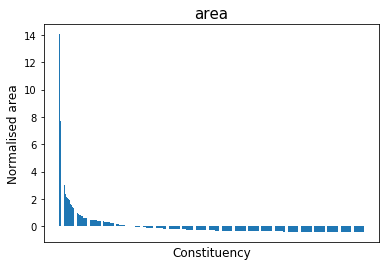

In [544]:
sorted_area = area_norm.sort_values(by=['Area'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_area['Constituency'], height=sorted_area['Area'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised area', fontsize=12)
plt.title('area', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

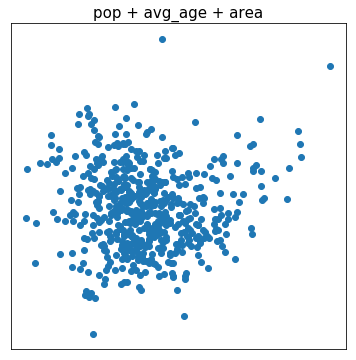

In [545]:
# plot the constituencies
fig = plt.figure(figsize=(6,6))

df = pd.merge(tot_pop_norm, avg_age_norm, on = ['Constituency'])
df = pd.merge(df, area_norm, on = ['Constituency'])

pca = PCA(n_components=2)
df_2d = pca.fit_transform(df.drop('Constituency', axis=1).set_index(df['Constituency']))

x = np.dot(df_2d, [1,0])
y = np.dot(df_2d, [0,1])

plt.scatter(x, y)
plt.title('pop + avg_age + area', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.show()

## House prices

We proceed with our fourth variable, median house price.

In [546]:
with open('house_prices.csv', 'r') as csv:
    house_prices = pd.read_csv(csv, usecols=[1,92])
    
house_prices.columns = ['Constituency', 'Median house price']

print(house_prices.shape)
house_prices.head()

(573, 2)


,Constituency,Median house price
0,Aldershot,213000
1,Aldridge-Brownhills,155000
2,Altrincham and Sale West,236000
3,Amber Valley,120000
4,Arundel and South Downs,299998


In [547]:
house_prices.describe()

,Median house price
count,573.000000
mean,190620.279232
std,96022.411166
min,62000.000000
25%,125000.000000
50%,165625.000000
75%,225000.000000
max,980000.000000


In [548]:
# normalise data
house_prices_norm = house_prices[['Constituency']].copy()
price = house_prices['Median house price']
house_prices_norm['Median house price'] = (price - price.mean()) / price.std()

house_prices_norm.head()

,Constituency,Median house price
0,Aldershot,0.233068
1,Aldridge-Brownhills,-0.370958
2,Altrincham and Sale West,0.472595
3,Amber Valley,-0.735456
4,Arundel and South Downs,1.139085


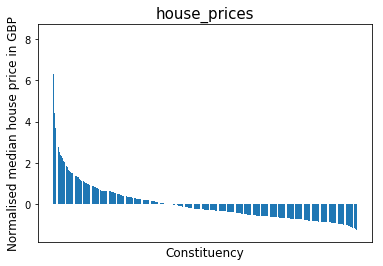

In [549]:
sorted_house_prices = house_prices_norm.sort_values(by=['Median house price'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_house_prices['Constituency'], height=sorted_house_prices['Median house price'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised median house price in GBP', fontsize=12)
plt.title('house_prices', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

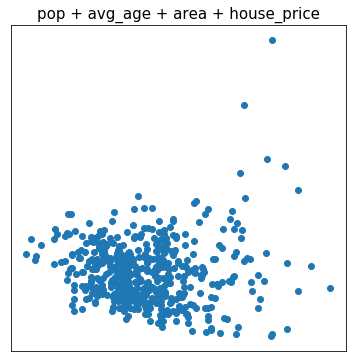

In [550]:
# plot the constituencies
fig = plt.figure(figsize=(6,6))

df = pd.merge(tot_pop_norm, avg_age_norm, on = ['Constituency'])
df = pd.merge(df, area_norm, on = ['Constituency'])
df = pd.merge(df, house_prices_norm, on = ['Constituency'])

pca = PCA(n_components=2)
df_2d = pca.fit_transform(df.drop('Constituency', axis=1).set_index(df['Constituency']))

x = np.dot(df_2d, [1,0])
y = np.dot(df_2d, [0,1])

plt.scatter(x, y)
plt.title('pop + avg_age + area + house_price', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.show()

## Businesses

Next up, business variables. We will be using both the total number of businesses as well as a so-called business profile, being the distribution of the different sectors the businesses belong to. The constituencies in this data set are of the form <tt>code: name</tt>, so we first extract the names.

In [551]:
def filter_constituency(x):
    if x == x.upper():
        return np.nan
    else:
        return x[10:].replace(':','').strip()

with open('business_2018.csv') as file:
    business = pd.read_csv(
        file, 
        header = 5, 
        names = ['Constituency'] + [f'Cat_{i}' for i in range(1,18)] + ['Businesses'],
        converters = {**{f'Cat_{i}' : str_to_int for i in range(1,18)}, **{'Constituency': filter_constituency, 'Businesses': str_to_int}}
    )

business = business.dropna().sort_values(by=['Constituency'])
business.reset_index(inplace=True, drop=True)

print(business.shape)
business.head()

(650, 19)


,Constituency,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,Cat_8,Cat_9,Cat_10,Cat_11,Cat_12,Cat_13,Cat_14,Cat_15,Cat_16,Cat_17,Businesses
0,Aberavon,40.0,125.0,190.0,55.0,65.0,120.0,60.0,145.0,65.0,20.0,30.0,140.0,120.0,0.0,20.0,65.0,115.0,1375.0
1,Aberconwy,280.0,115.0,240.0,80.0,55.0,195.0,55.0,360.0,75.0,35.0,60.0,245.0,150.0,5.0,25.0,115.0,160.0,2250.0
2,Aberdeen North,20.0,115.0,205.0,40.0,70.0,195.0,95.0,190.0,120.0,20.0,65.0,735.0,195.0,0.0,35.0,110.0,165.0,2375.0
3,Aberdeen South,60.0,275.0,330.0,70.0,135.0,215.0,110.0,255.0,240.0,100.0,225.0,2155.0,495.0,0.0,50.0,150.0,250.0,5115.0
4,Airdrie and Shotts,65.0,155.0,290.0,90.0,65.0,185.0,165.0,155.0,70.0,30.0,40.0,200.0,145.0,0.0,10.0,60.0,135.0,1860.0


### Total amount of business

We treat the first business variable, total business, just like the previous variables.

In [552]:
tot_business = business[['Constituency', 'Businesses']].copy()
tot_business.describe()

,Businesses
count,650.000000
mean,4106.830769
std,3078.665083
min,1190.000000
25%,2771.250000
50%,3700.000000
75%,4865.000000
max,66355.000000


In [553]:
# normalise data
tot_business_norm = tot_business[['Constituency']].copy()
businesses = tot_business['Businesses']
tot_business_norm['Businesses'] = (businesses - businesses.mean()) / businesses.std()

tot_business_norm.head()

,Constituency,Businesses
0,Aberavon,-0.887343
1,Aberconwy,-0.603129
2,Aberdeen North,-0.562527
3,Aberdeen South,0.327470
4,Airdrie and Shotts,-0.729807


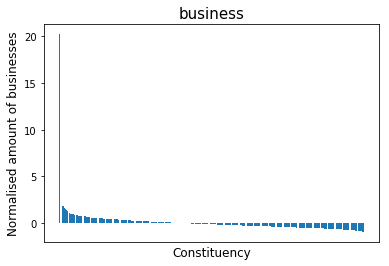

In [554]:
sorted_business = tot_business_norm.sort_values(by=['Businesses'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_business['Constituency'], height=sorted_business['Businesses'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised amount of businesses', fontsize=12)
plt.title('business', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

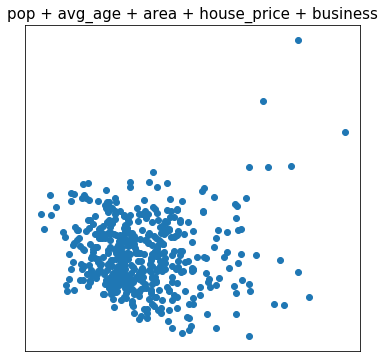

In [555]:
# plot the constituencies
fig = plt.figure(figsize=(6,6))

df = pd.merge(tot_pop_norm, avg_age_norm, on = ['Constituency'])
df = pd.merge(df, area_norm, on = ['Constituency'])
df = pd.merge(df, house_prices_norm, on = ['Constituency'])
df = pd.merge(df, tot_business_norm, on = ['Constituency'])

pca = PCA(n_components=2)
df_2d = pca.fit_transform(df.drop('Constituency', axis=1).set_index(df['Constituency']))

x = np.dot(df_2d, [1,0])
y = np.dot(df_2d, [0,1])

plt.scatter(x, y)
plt.title('pop + avg_age + area + house_price + business', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.show()

### Business profile

To get the business profile, we use a Principal Component Analysis on the distribution of the 17 different business sectors.

In [556]:
business_profile = business.copy()
business_profile.drop('Businesses', axis=1, inplace=True)

for col in business_profile.columns[1:]:
    business_profile[col] = business_profile[col] / tot_business['Businesses']
    profile = business_profile[col]

business_profile.head()

,Constituency,Cat_1,Cat_2,Cat_3,Cat_4,Cat_5,Cat_6,Cat_7,Cat_8,Cat_9,Cat_10,Cat_11,Cat_12,Cat_13,Cat_14,Cat_15,Cat_16,Cat_17
0,Aberavon,0.029091,0.090909,0.138182,0.040000,0.047273,0.087273,0.043636,0.105455,0.047273,0.014545,0.021818,0.101818,0.087273,0.000000,0.014545,0.047273,0.083636
1,Aberconwy,0.124444,0.051111,0.106667,0.035556,0.024444,0.086667,0.024444,0.160000,0.033333,0.015556,0.026667,0.108889,0.066667,0.002222,0.011111,0.051111,0.071111
2,Aberdeen North,0.008421,0.048421,0.086316,0.016842,0.029474,0.082105,0.040000,0.080000,0.050526,0.008421,0.027368,0.309474,0.082105,0.000000,0.014737,0.046316,0.069474
3,Aberdeen South,0.011730,0.053763,0.064516,0.013685,0.026393,0.042033,0.021505,0.049853,0.046921,0.019550,0.043988,0.421310,0.096774,0.000000,0.009775,0.029326,0.048876
4,Airdrie and Shotts,0.034946,0.083333,0.155914,0.048387,0.034946,0.099462,0.088710,0.083333,0.037634,0.016129,0.021505,0.107527,0.077957,0.000000,0.005376,0.032258,0.072581


In [557]:
pca = PCA(n_components=1)
business_profile_1d = pca.fit_transform(business_profile.drop(['Constituency'], axis=1).set_index(business_profile['Constituency']))

business_profile['Business profile'] = business_profile_1d

business_profile[['Constituency', 'Business profile']].describe()

,Business profile
count,6.500000e+02
mean,4.187356e-18
std,9.169208e-02
min,-1.555307e-01
25%,-5.414906e-02
50%,-1.803216e-02
75%,2.413498e-02
max,4.117748e-01


In [558]:
# normalise
business_profile_norm = business_profile[['Constituency', 'Business profile']].copy()
profile = business_profile_norm['Business profile']
business_profile_norm['Business profile'] = (profile - profile.mean()) / profile.std()

business_profile_norm.head()

,Constituency,Business profile
0,Aberavon,0.172734
1,Aberconwy,1.077172
2,Aberdeen North,-1.032843
3,Aberdeen South,-1.531703
4,Airdrie and Shotts,0.252810


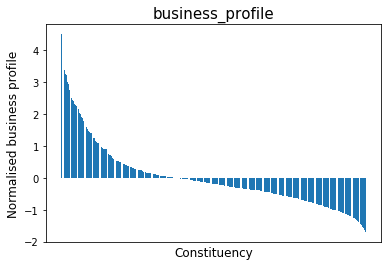

In [559]:
sorted_business_profile = business_profile_norm.sort_values(by=['Business profile'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_business_profile['Constituency'], height=sorted_business_profile['Business profile'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised business profile', fontsize=12)
plt.title('business_profile', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

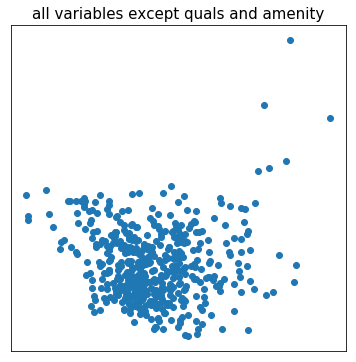

In [560]:
# plot the constituencies
fig = plt.figure(figsize=(6,6))

df = pd.merge(tot_pop_norm, avg_age_norm, on = ['Constituency'])
df = pd.merge(df, area_norm, on = ['Constituency'])
df = pd.merge(df, house_prices_norm, on = ['Constituency'])
df = pd.merge(df, tot_business_norm, on = ['Constituency'])
df = pd.merge(df, business_profile_norm, on = ['Constituency'])


pca = PCA(n_components=2)
df_2d = pca.fit_transform(df.drop('Constituency', axis=1).set_index(df['Constituency']))

x = np.dot(df_2d, [1,0])
y = np.dot(df_2d, [0,1])

plt.scatter(x, y)
plt.title('all variables except quals and amenity', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.show()

## Qualifications

We proceed with the qualifications variable in the same manner as the business profile variable.

In [561]:
def filter_constituency(x):
    if x == x.upper():
        return np.nan
    else:
        return x[10:].replace(':','').strip()

with open('quals_2011.csv') as file:
    quals = pd.read_csv(
        file,
        header = 0,
        usecols = [0,1,2,3,5,6],
        names = ['Code', 'No quals', 'Level 1', 'Level 2', 'Level 3', 'Level 4']
    )

quals = pd.merge(constituencies[['Constituency', 'Code']], quals, on = ['Code']).drop('Code', axis=1)
quals.dropna()

print(quals.shape)
quals.head()

(650, 6)


,Constituency,No quals,Level 1,Level 2,Level 3,Level 4
0,Aldershot,18.5,16.4,17.1,12.5,25.0
1,Aldridge-Brownhills,29.5,14.0,16.0,11.7,20.5
2,Altrincham and Sale West,15.2,11.1,15.2,11.4,40.3
3,Amber Valley,29.7,14.8,15.9,12.0,18.7
4,Arundel and South Downs,17.9,12.5,17.2,12.0,33.0


In [562]:
pca = PCA(n_components=1)
quals_1d = pca.fit_transform(quals.drop('Constituency', axis=1).set_index(quals['Constituency']))
quals['Qualifications'] = quals_1d

quals[['Constituency', 'Qualifications']].describe()

,Qualifications
count,6.500000e+02
mean,2.587332e-15
std,1.016467e+01
min,-2.343955e+01
25%,-7.508463e+00
50%,-9.680842e-01
75%,5.677017e+00
max,3.407730e+01


In [563]:
# normalise
quals_norm = quals[['Constituency', 'Qualifications']].copy()
quals_series = quals['Qualifications']
quals_norm['Qualifications'] = (quals_series - quals_series.mean()) / quals_series.std()

quals_norm.head()

,Constituency,Qualifications
0,Aldershot,0.070576
1,Aldridge-Brownhills,-0.813235
2,Altrincham and Sale West,1.584553
3,Amber Valley,-0.981112
4,Arundel and South Downs,0.815145


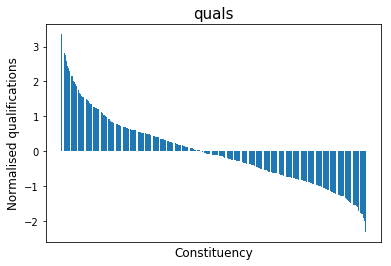

In [564]:
sorted_quals = quals_norm.sort_values(by=['Qualifications'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_quals['Constituency'], height=sorted_quals['Qualifications'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised qualifications', fontsize=12)
plt.title('quals', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

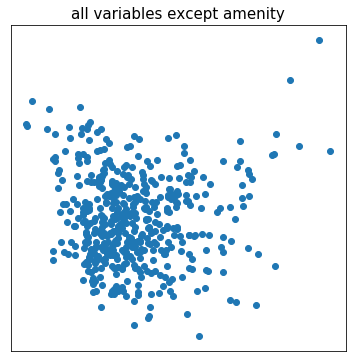

In [565]:
# plot the constituencies
fig = plt.figure(figsize=(6,6))

df = pd.merge(tot_pop_norm, avg_age_norm, on = ['Constituency'])
df = pd.merge(df, area_norm, on = ['Constituency'])
df = pd.merge(df, house_prices_norm, on = ['Constituency'])
df = pd.merge(df, tot_business_norm, on = ['Constituency'])
df = pd.merge(df, business_profile_norm, on = ['Constituency'])
df = pd.merge(df, quals_norm, on = ['Constituency'])


pca = PCA(n_components=2)
df_2d = pca.fit_transform(df.drop('Constituency', axis=1).set_index(df['Constituency']))

x = np.dot(df_2d, [1,0])
y = np.dot(df_2d, [0,1])

plt.scatter(x, y)
plt.title('all variables except amenity', fontsize=15)
plt.xticks([])
plt.yticks([])

plt.show()

## Amenity data from Foursquare

As for the amenity data, we are not simply loading in a data set as before. We will be using the Foursquare API to gather up information about nearby amenities, and store the amenity categories of these.

### Fetching data from the Foursquare API

The following is my personal client id and secret, meaning that it can only be used a limited amount of times a day (around 5,000 calls per day). The next two functions are used to construct API calls given location coordinates and gathering data about the nearby amenities, respectively.

In [566]:
CLIENT_ID = '1CNA4A03C1G0DWB3U1MQLXRIX2L4HNONAH3JPPIPE3DW4I12' # Foursquare ID
CLIENT_SECRET = '5WQAJ1DW11TJ3O4HBCTSD1OPSXZSFU331BJ1EQ4F2HRQVN5P' # Foursquare Secret
VERSION = '20190428' # Foursquare API version

In [567]:
def get_url(lat, lng, radius=250, limit=100):
    url = f"https://api.foursquare.com/v2/venues/explore?" \
            f"client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&" \
            f"v={VERSION}&ll={lat},{lng}&radius={radius}"
    if limit == None:
            return url
    else:
        return f"{url}&limit={limit}"

def get_amenities(names, latitudes, longitudes, radius=500, limit=100):
    
    amenities_arr = np.asarray([])
    names_arr = np.asarray([])
    i = 0
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = get_url(lat=lat, lng=lng, radius=radius, limit=limit)
        
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            continue
        
        # return only relevant information for each nearby amenity
        names_arr = np.append(names_arr, np.asarray([name] * len(results)))
        amenities_arr = np.append(amenities_arr, [a['venue']['categories'][0]['name'] for a in results])
        
        i += 1        
        print(f"Fetched amenities in {i} constituencies...", end = '\r')
        
    nearby_amenities = pd.DataFrame({'Constituency' : names_arr, 'Amenity Category' : amenities_arr})
    
    return(nearby_amenities)

Next step is to get the desired amenities in all of our constituencies. Calling the API takes a few minutes, and can be done by running the following code. Alternatively, I have downloaded this already and stored it in the amenities.pickle file, which you downloaded in the beginning, so you can simply load this in. Up to you.

In [568]:
# load dataframe    
with open(f"amenities.pickle", "rb") as pickle_in:
    amenities = pickle.load(pickle_in)

# find number of unique categories
unique_cats = amenities['Amenity Category'].unique()

print(f"Found {amenities.shape[0]} amenities spread among {len(unique_cats)} unique categories. Here are a few of them:")
amenities.head()

Found 40096 amenities spread among 430 unique categories. Here are a few of them:


,Constituency,Amenity Category
0,Aldershot,Hotel
1,Aldershot,Airport
2,Aldershot,Café
3,Aldershot,Warehouse Store
4,Aldershot,Hotel Bar


### Cleaning amenity data

Now, we do a one hot encoding of our amenitiy categories and find the frequency of every amenity by constituency.

In [569]:
# one hot encoding
amenities_onehot = pd.get_dummies(amenities['Amenity Category'], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
amenities_onehot['Constituency'] = amenities['Constituency'] 

# move neighbourhood column to the first column
fixed_columns = [amenities_onehot.columns[-1]] + list(amenities_onehot.columns[:-1])
amenities_onehot = amenities_onehot[fixed_columns]

amenities_onehot.head()

,Constituency,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Aldershot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Aldershot,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aldershot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Aldershot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Aldershot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [570]:
amenities_mean = amenities_onehot.groupby('Constituency', as_index=False).mean()
print(amenities_mean.shape)
amenities_mean.head()

(649, 431)


,Constituency,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Aberavon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aberconwy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aberdeen North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aberdeen South,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Airdrie and Shotts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the same manner as the business profile and the qualifications variables, we perform a Principal Component Analysis on the amenity categories, to end up with a one-dimensional variable.

In [571]:
pca = PCA(n_components=1)
amenities_1d = pca.fit_transform(amenities_mean.drop(['Constituency'], axis=1).set_index(amenities_mean['Constituency']))
amenities_mean['Amenities'] = amenities_1d

amenities_mean[['Constituency', 'Amenities']].describe()

,Amenities
count,6.490000e+02
mean,3.624476e-18
std,9.364168e-02
min,-1.583099e-01
25%,-5.563816e-02
50%,-8.050333e-03
75%,3.239887e-02
max,6.472416e-01


In [572]:
# normalise
amenities_1d_norm = amenities_mean[['Constituency', 'Amenities']].copy()
amenities_series = amenities_1d_norm['Amenities']
amenities_1d_norm['Amenities'] = (amenities_series - amenities_series.mean()) / amenities_series.std()

amenities_1d_norm.head()

,Constituency,Amenities
0,Aberavon,-0.215277
1,Aberconwy,0.283899
2,Aberdeen North,-0.779669
3,Aberdeen South,-0.792791
4,Airdrie and Shotts,-0.816157


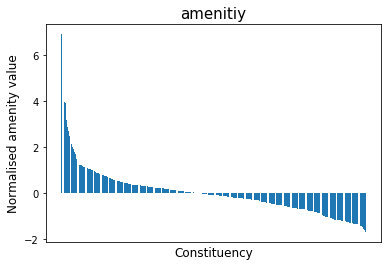

In [573]:
sorted_amenities = amenities_1d_norm.sort_values(by=['Amenities'], ascending=False)

plt.figure(figsize=(6,4))
plt.bar(x=sorted_amenities['Constituency'], height=sorted_amenities['Amenities'])
plt.xlabel('Constituency', fontsize=12)
plt.ylabel('Normalised amenity value', fontsize=12)
plt.title('amenitiy', fontsize=15)
plt.tick_params(bottom=False, labelbottom=False) # disable ticks and labels along the bottom edge
plt.show()

## Clustering constituencies

Now that we have all our variables, we gather them up in one data frame, <tt>all_info</tt>.

In [574]:
all_info = tot_pop_norm.copy()
all_info = pd.merge(all_info, area_norm, on=['Constituency'])
all_info = pd.merge(all_info, avg_age_norm, on=['Constituency'])
all_info = pd.merge(all_info, house_prices_norm, on=['Constituency'])
all_info = pd.merge(all_info, tot_business_norm, on=['Constituency'])
all_info = pd.merge(all_info, business_profile_norm, on=['Constituency'])
all_info = pd.merge(all_info, amenities_1d_norm, on=['Constituency'])
all_info = pd.merge(all_info, quals_norm, on=['Constituency'])

print(all_info.shape)
all_info.head()

(500, 9)


,Constituency,Population,Area,Avg age,Median house price,Businesses,Business profile,Amenities,Qualifications
0,Aldershot,0.230191,-0.360126,-0.561755,0.233068,-0.120777,-0.804685,0.726880,0.070576
1,Aldridge-Brownhills,-1.566569,-0.370277,0.893047,-0.370958,-0.531669,-0.083996,0.296707,-0.813235
2,Altrincham and Sale West,-0.066709,-0.362446,0.057923,0.472595,0.689640,-1.214955,0.226183,1.584553
3,Amber Valley,-0.776674,-0.278939,0.661315,-0.735456,-0.390374,0.277779,-0.017484,-0.981112
4,Arundel and South Downs,-0.126641,0.312234,1.679105,1.139085,0.637669,0.067044,0.120536,0.815145


We do a final visualisation of the distribution of the constituencies, given all our variables.

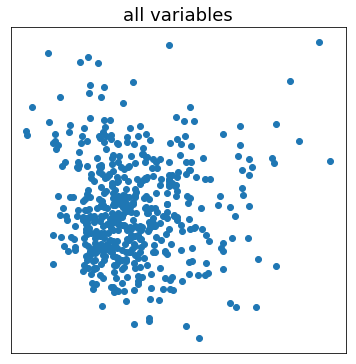

In [575]:
pca = PCA(n_components=2)
all_info_2d = pca.fit_transform(all_info.drop(['Constituency'], axis=1).set_index(all_info['Constituency']))

# plot the constituencies
fig = plt.figure(figsize=(6,6))

x = np.dot(all_info_2d, [1,0])
y = np.dot(all_info_2d, [0,1])

plt.scatter(x, y)
plt.title('all variables', fontsize=18)
plt.xticks([])
plt.yticks([])

plt.show()

We want to use the k-means clustering algorithm, so we have to find a suitable k. We will use the "elbow method", except that the first elbow was at k=8, which yielded too large clusters for our use case, so we find the next elbow after that point.

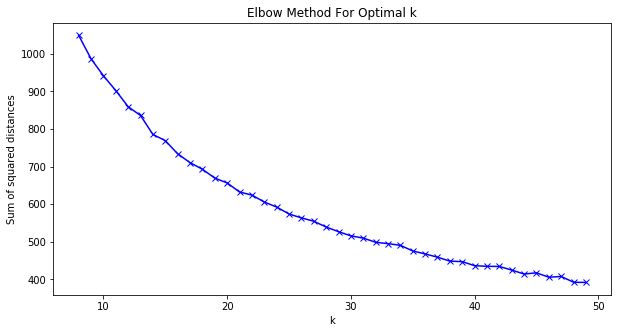

In [576]:
Sum_of_squared_distances = []
K = range(8,50)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(all_info.drop('Constituency', 1))
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We find the second elbow to be at k=18, so we run the k-means clustering algorithm for this choice of k.

In [577]:
# set number of clusters
kclusters = 18

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_info.drop('Constituency', 1))
labels = kmeans.labels_

print("K-means algorithm finished!")

K-means algorithm finished!


Here is a visualisation of the clusters.

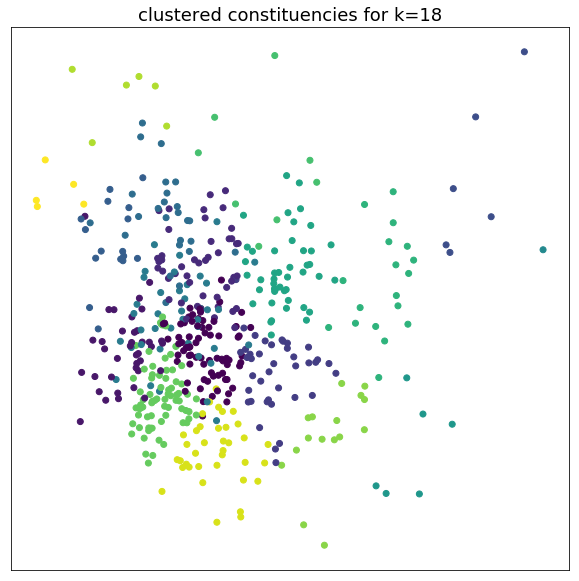

In [578]:
pca = PCA(n_components=2)
all_info_2d = pca.fit_transform(all_info.drop(['Constituency'], axis=1).set_index(all_info['Constituency']))

# plot the constituencies
fig = plt.figure(figsize=(10,10))

x = np.dot(all_info_2d, [1,0])
y = np.dot(all_info_2d, [0,1])

plt.scatter(x, y, c=labels)
plt.title('clustered constituencies for k=18', fontsize=18)
plt.xticks([])
plt.yticks([])

plt.show()

Next, we add in the cluster labels to a new data frame <tt>nbhd_clusters</tt>, and find the distribution of the clusters.

In [579]:
# create copy of nbhds_venues_sorted
nbhd_clusters = all_info.copy()[['Constituency']]

# add clustering labels
nbhd_clusters.insert(0, 'Cluster labels', labels)

# merge bristol_grouped with bristol data to add latitude/longitude for each neighborhood
nbhd_clusters = constituencies.join(nbhd_clusters.set_index('Constituency'), on='Constituency')

# drop neighbourhoods with no venues
nbhd_clusters.dropna(subset=['Cluster labels'], inplace=True)

# convert cluster labels to integers
nbhd_clusters['Cluster labels'] = nbhd_clusters['Cluster labels'].astype('int32')

print(nbhd_clusters.shape)
nbhd_clusters.head()

(500, 5)


,Constituency,Latitude,Longitude,Code,Cluster labels
0,Aldershot,51.277500,-0.762801,E14000530,3
1,Aldridge-Brownhills,52.614201,-1.927900,E14000531,1
2,Altrincham and Sale West,53.394199,-2.342090,E14000532,10
3,Amber Valley,53.047901,-1.388680,E14000533,1
4,Arundel and South Downs,50.912498,-0.415972,E14000534,2


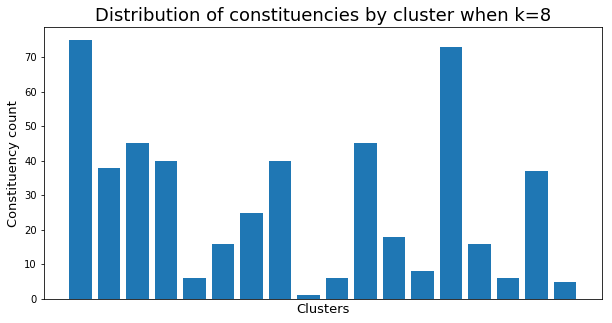

In [580]:
# find total amount of clusters
total_clusters = len(nbhd_clusters['Cluster labels'].unique())

# count how many sectors are in each cluster
cluster_count = nbhd_clusters.groupby(['Cluster labels']).count()['Constituency']

# plot distribution of clusters
plt.figure(figsize=(10,5))
plt.bar(x=cluster_count.index, height=cluster_count.values)
plt.xlabel('Clusters', fontsize=13)
plt.ylabel('Constituency count', fontsize=13)
plt.title('Distribution of constituencies by cluster when k=8', fontsize=18)
plt.xticks([])
plt.show()

For the big finale, we find all the similar constituencies to a given area. Feel free to change the following area to be whatever you would like.

In [581]:
# Set your current area, or leave blank if you want to see all clusters
current_area = 'Bristol'

In [582]:
# set up geocoder
geocoder = opencage.geocoder.OpenCageGeocode('3021fe0dd4174d68bdcb156dbe1974e4')

def get_coords(query):
    return list(geocoder.geocode(query)[0]['geometry'].values())

england_coords = get_coords('England')

In [583]:
current_cluster = ''
if current_area:
    # get coordinates
    current_coords = get_coords(current_area)

    # get postcode
    with request.urlopen(f"https://www.doogal.co.uk/GetPostcodesNear.ashx?lat={current_coords[0]}&lng={current_coords[1]}") as url_data:
        soup = BeautifulSoup(url_data, 'xml')

    postcode_list = []
    for postcode in soup.postcodes.find_all('postcode'):
        code = postcode['code']
        distance = postcode['distance']
        postcode_list.append([code, distance])

    df = pd.DataFrame(postcode_list)
    df.columns = ['Postcode', 'Distance']
    postcodes = df.sort_values(by=['Distance']).head(10)['Postcode'].values
    
    current_constituency = ''
    for postcode in postcodes:
        if current_constituency == '':
            current_postcode = postcode.replace(' ','')

            # get constituency
            try:
                with request.urlopen(f"https://www.doogal.co.uk/GetPostcode.ashx?postcode={current_postcode}") as url_data:
                    soup = BeautifulSoup(url_data)
                current_constituency = soup.p.string.split('\t')[4]
            except:
                pass
    
    if current_constituency == '':
        print("Constituency not found!")
    else:
        # get cluster
        current_cluster = nbhd_clusters.loc[nbhd_clusters['Constituency'] == current_constituency]['Cluster labels'].values[0]
        print(f"'{current_area}' is in {current_postcode} which belongs to the constituency '{current_constituency}' which is in cluster {current_cluster}.")

'Bristol' is in BS11XG which belongs to the constituency 'Bristol West' which is in cluster 9.


In [584]:
# create map
map_clusters = folium.Map(location=england_coords, zoom_start=6, tiles="Stamen Toner")

# set color scheme for the clusters
x = np.arange(total_clusters)
ys = [i + x + (i*x)**2 for i in range(total_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]
shuffle(rainbow)

# add markers to the map
markers_colors = []
for lat, lng, constituency, cluster in zip(nbhd_clusters['Latitude'], nbhd_clusters['Longitude'], nbhd_clusters['Constituency'], nbhd_clusters['Cluster labels']):
    if cluster == current_cluster or current_area == '':
        label = folium.Popup(str(constituency) + f'\nCluster {cluster}', parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=1).add_to(map_clusters)

map_clusters

To have an idea of what the clusters represent, we end with an overview of the average values of all the variables in each cluster.

In [585]:
df = all_info.drop('Constituency', axis=1)
df.insert(0, 'Cluster labels', labels)
df = df.groupby(['Cluster labels']).mean()
df

,Population,Area,Avg age,Median house price,Businesses,Business profile,Amenities,Qualifications
Cluster labels,,,,,,,,
0,-0.070440,-0.257091,0.079528,-0.243332,-0.142691,-0.255150,0.112945,-0.114731
1,-1.401256,-0.194999,0.547526,-0.741989,-0.611762,0.272481,-0.281927,-0.759497
2,-0.487187,-0.085357,1.037039,0.167792,0.087394,-0.176738,0.201673,0.491026
3,0.540106,-0.354782,-0.990882,0.207899,-0.040912,-0.771263,0.248328,0.556857
4,1.264557,-0.403531,-0.884635,4.990204,1.290549,-1.322378,-0.707441,2.985647
5,-0.820722,0.933690,1.469562,-0.230700,0.111162,2.141565,-0.644411,-0.164179
6,-0.592609,0.169385,1.208661,-0.046992,0.018699,0.744969,1.599688,0.254448
7,0.115881,0.340703,0.848765,-0.151365,0.112279,0.742424,-1.031596,-0.091613
8,3.240381,-0.405194,-1.323532,3.430238,6.565563,-1.696229,-1.163936,2.154232
